In [5]:
!pip uninstall -y numpy scipy
!pip install numpy==1.26.4
!pip install scipy gensim

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, which is not installed.
cuml-cu12 25.2.1 requires scipy>=1.8.0, which is not installed.
hyperopt 0.2.7 requires scipy, which is not installed.
missingno 0.5.2 requires scipy, which is not installed.
pytensor 2.28.3 requires scipy<2,>=1, which is not installed.
pymc 5.21.1 requires scipy>=1.4.1, which is not installed.
umap-learn 0.5.7 requires scipy>=1.3.1, whic

In [1]:
import json
from keras.layers import LSTM, Dense, Embedding, Input
from keras.models import Sequential
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

from dl_utils import plot_history

import gensim

#Load data

In [2]:
with open('game_review.json') as file:
    X = []
    y = []
    data = json.load(file)
    for _, review in data["reviews"].items():
        X.append(review["review"])
        y.append(review["votes_funny"])

X = np.array(X)
y = np.array(y)

In [3]:
print(X[:10])
print(y[:10])

['Game runs amazingly and having a ton of fun :) no valstrax though ;('
 'This game is a disgrace to the Monster Hunter IP. Do better Capcom.'
 "It's the most accessible and detailed monster hunter title to date. The weapons have mostly seen big improvements with the bowguns being a noticeable downgrade from previous titles. There's so much to do with so much detail to breathe life into the environments. My favorite moments have been discovering music in a camp with my friends and taking on a giant ice wyrm on a mountain. Highly recommend."
 'as a gamer i have a right to get destroyed when I want, and right now this game does not offer that'
 "Currently, I have not run into a majority of graphical errors that most people have. What few I did run into, were very breif, but highly distracting. After the few updates done, I've yet to encounter the same errors again.\r\n\r\nThis game is a logical evolution of MH world and MH Rise. The hub integrated into the hunting enviorment creates a li

#Reformat data

In [4]:
def text_to_words(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\\s', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    return words
# Doesn't currently keep punctuation, caps, emojies, ... -> maybe also hold some informational value

In [5]:
# Splits each review text in lists of words
X_words = [text_to_words(text) for text in X]

In [6]:
import gensim.downloader as api

In [7]:
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [33]:
def words_to_vectors(words, model, vector_size=300):
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])  # Get the word vector
        else:
            vectors.append(np.zeros(vector_size))  # Use zero vector for unknown words
    return np.array(vectors)  # Return a NumPy array of shape (num_words, 300)

# Embed each review (list of word vectors)
X_vectors = [words_to_vectors(words, model) for words in X_words]

np.save("word_vectors.npy", np.array(X_vectors, dtype=object))

loaded_vectors = np.load("word_vectors.npy", allow_pickle=True)

# Print an example
print(f"First review shape: {X_vectors[0].shape}")  # Example output: (11, 300)

First review shape: (12, 300)


In [32]:
print(X_vectors[0])
print(X_words[0])

[[ 0.11474609  0.05273438  0.04296875 ... -0.09423828 -0.17285156
  -0.05273438]
 [-0.08642578  0.1328125  -0.09472656 ... -0.23828125 -0.0612793
   0.00567627]
 [ 0.11132812 -0.16015625 -0.24707031 ... -0.16601562  0.05957031
   0.15722656]
 ...
 [ 0.08251953 -0.15136719  0.06591797 ... -0.1015625  -0.10839844
  -0.20507812]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.08935547  0.01953125 -0.03515625 ... -0.05151367  0.18261719
  -0.03015137]]
['game', 'runs', 'amazingly', 'and', 'having', 'a', 'ton', 'of', 'fun', 'no', 'valstrax', 'though']


In [ ]:
# Makes dictionaries for tokenizing and detokenizing words
unique_words = sorted(set(word for sublist in X_words for word in sublist))

word_to_id = {word: idx + 1 for idx, word in enumerate(unique_words)} # Reserve zero for padding
id_to_word = {idx: word for word, idx in word_to_id.items()}

In [ ]:
# Tokenizes words
X_tokenized = [[word_to_id[word] for word in sublist] for sublist in X_words]

In [ ]:
# Pads tokenized words to the length of the longest review in words
maxlen = len(max(X_tokenized, key=len))
X_tokenized_padded = sequence.pad_sequences(X_tokenized, maxlen=maxlen)

In [ ]:
print(X_words[0])
print(X_tokenized_padded[0])

['game', 'runs', 'amazingly', 'and', 'having', 'a', 'ton', 'of', 'fun', 'no', 'valstrax', 'though']
[    0     0     0 ... 16244 25004 23621]


0: 16527
1: 535
2: 84
3: 24
4: 17
5: 3
6: 1
7: 1
8: 1
9: 2
10: 2
11: 1
15: 1
21: 1


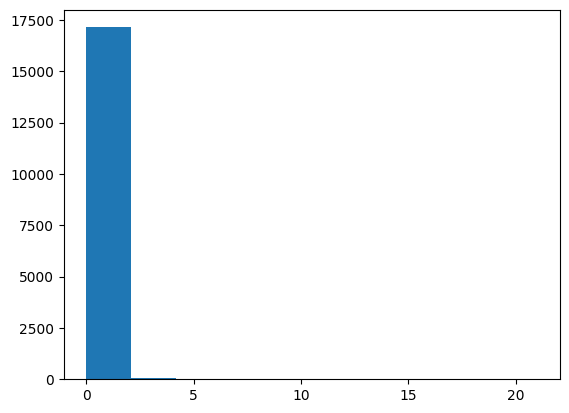

In [ ]:
# Distribution of outcome values
plt.hist(y)

unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

Let's try binary (True if > 0) -> can be changed to different cutoffs or even more categories

0.0: 16527
1.0: 673


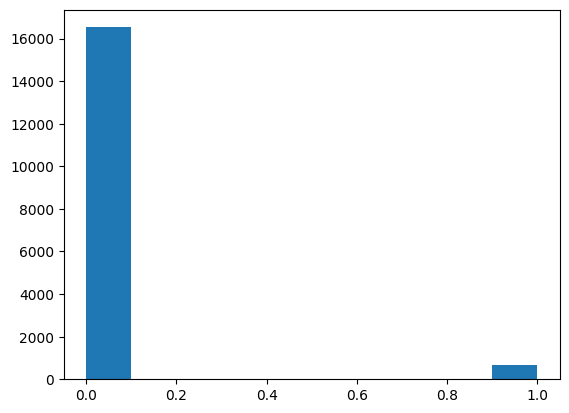

In [ ]:
# Changing the outcome to binary
y_binary = (y > 0).astype("float32")
plt.hist(y_binary)

unique, counts = np.unique(y_binary, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

#Splitting dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tokenized_padded, y_binary, test_size=0.2, random_state=42, stratify=y_binary)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
print(X_train.shape, "training set")
print(X_val.shape, "validation set")
print(X_test.shape, "test set")

(11008, 1495) training set
(2752, 1495) validation set
(3440, 1495) test set


#Model

In [ ]:
max_features = len(unique_words) + 1

In [ ]:
def Rnnmodel(embedding_size = 128, dropoutrate = 0.2, recurrent_dropoutrate = 0.2, lr = 0.001):
  model = Sequential()
  model.add(Embedding(max_features, embedding_size))
  model.add(LSTM(32, dropout=dropoutrate, recurrent_dropout=recurrent_dropoutrate))
  model.add(Dense(1, activation="sigmoid"))
  optimizer = keras.optimizers.AdamW(learning_rate=lr)
  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

In [ ]:
model1 = Rnnmodel()
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.9388 - loss: 0.3291 - val_accuracy: 0.9608 - val_loss: 0.1642
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.9588 - loss: 0.1669 - val_accuracy: 0.9608 - val_loss: 0.1626
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9625 - loss: 0.1483 - val_accuracy: 0.9608 - val_loss: 0.1627


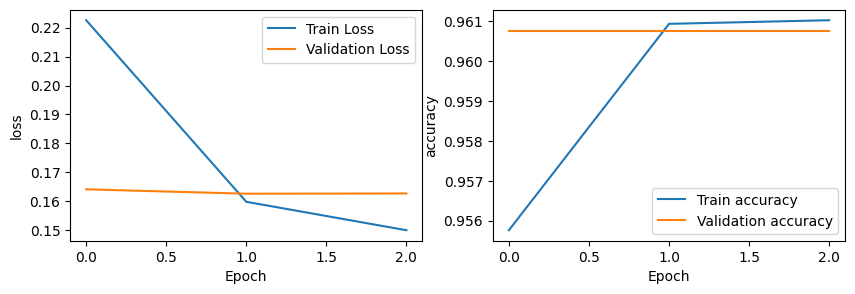

In [ ]:
history = model1.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_val, y_val))
plot_history(history)

In [ ]:
score = model1.evaluate(X_val, y_val, verbose=0)

print("Validation loss:", score[0])
print("Validation accuracy:", score[1])

Validation loss: 0.16273336112499237
Validation accuracy: 0.9607558250427246


86/86 ━━━━━━━━━━━━━━━━━━━━ 65s 752ms/step


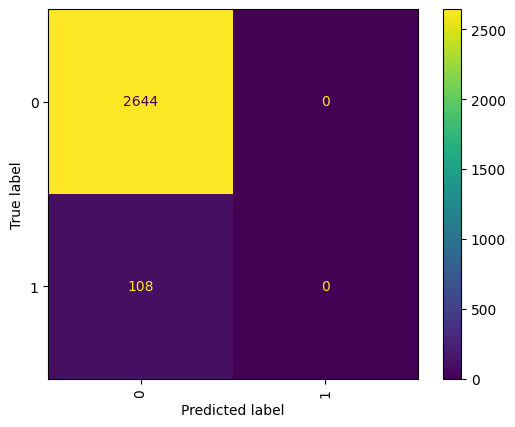

In [ ]:
# Confusion matrix (validation set)
y_pred = model1.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
_ = plt.xticks(rotation=90)

It basically predicts them all as not funny. Accuracy is not important! -> look into solutions for class imbalance

##Different loss function

In [ ]:
# Chat-GPT generated code
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Compute focal loss for binary classification.
    :param alpha: Balancing factor for positive class
    :param gamma: Focusing parameter
    """
    def loss(y_true, y_pred):
        y_pred = keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_weight = alpha_factor * keras.backend.pow((1 - p_t), gamma)
        return keras.backend.mean(focal_weight * keras.backend.binary_crossentropy(y_true, y_pred))

    return loss

def precision(y_true, y_pred):
    """Compute precision metric."""
    tp = keras.backend.sum(keras.backend.round(y_true * y_pred))
    fp = keras.backend.sum(keras.backend.round((1 - y_true) * y_pred))
    return tp / (tp + fp + keras.backend.epsilon())

def recall(y_true, y_pred):
    """Compute recall metric."""
    tp = keras.backend.sum(keras.backend.round(y_true * y_pred))
    fn = keras.backend.sum(keras.backend.round(y_true * (1 - y_pred)))
    return tp / (tp + fn + keras.backend.epsilon())

def f1_score(y_true, y_pred):
    """Compute F1-score metric."""
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + keras.backend.epsilon())

In [ ]:
def Rnnmodel_focal_loss(embedding_size = 128, dropoutrate = 0.2, recurrent_dropoutrate = 0.2, lr = 0.001, alpha = 0.25, gamma = 2):
  model = Sequential()
  model.add(Embedding(max_features, embedding_size))
  model.add(LSTM(32, dropout=dropoutrate, recurrent_dropout=recurrent_dropoutrate))
  model.add(Dense(1, activation="sigmoid"))
  optimizer = keras.optimizers.AdamW(learning_rate=lr)
  model.compile(loss=focal_loss(alpha=alpha, gamma=gamma), optimizer=optimizer, metrics=["accuracy", f1_score])
  return model

In [ ]:
model2 = Rnnmodel_focal_loss()
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.9274 - f1_score: 0.0072 - loss: 0.0434 - val_accuracy: 0.9608 - val_f1_score: 0.0000e+00 - val_loss: 0.0156
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.9624 - f1_score: 1.0719e-04 - loss: 0.0148 - val_accuracy: 0.9608 - val_f1_score: 0.0000e+00 - val_loss: 0.0156
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.9613 - f1_score: 8.0960e-04 - loss: 0.0140 - val_accuracy: 0.9608 - val_f1_score: 0.0000e+00 - val_loss: 0.0158


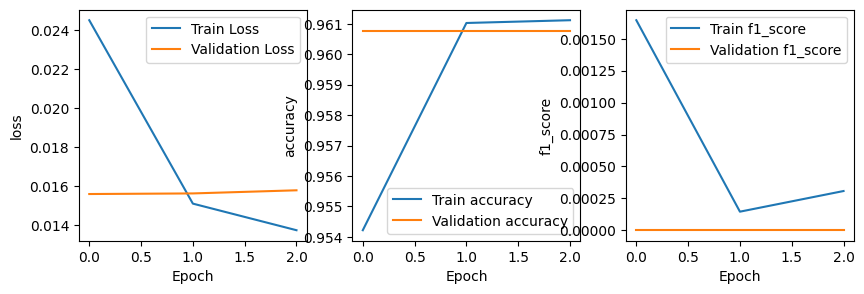

In [ ]:
history = model2.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_val, y_val))
plot_history(history)

In [ ]:
score = model2.evaluate(X_val, y_val, verbose=0)

print("Validation loss:", score[0])
print("Validation accuracy:", score[1])
print("Validation F1-score:", score[2])

Validation loss: 0.01580115593969822
Validation accuracy: 0.9607558250427246
Validation F1-score: 0.0


86/86 ━━━━━━━━━━━━━━━━━━━━ 67s 778ms/step


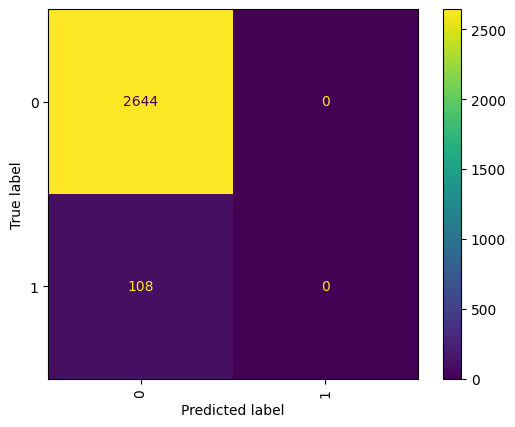

In [ ]:
# Confusion matrix (validation set)
y_pred = model2.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
_ = plt.xticks(rotation=90)

Set alpha to the class frequency of the majority class

In [ ]:
model3 = Rnnmodel_focal_loss(alpha=0.961)
model3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.8251 - f1_score: 0.0316 - loss: 0.0123 - val_accuracy: 0.4426 - val_f1_score: 0.0730 - val_loss: 0.0127
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.5689 - f1_score: 0.0734 - loss: 0.0121 - val_accuracy: 0.6722 - val_f1_score: 0.0688 - val_loss: 0.0132
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.7614 - f1_score: 0.0667 - loss: 0.0088 - val_accuracy: 0.7638 - val_f1_score: 0.0649 - val_loss: 0.0168


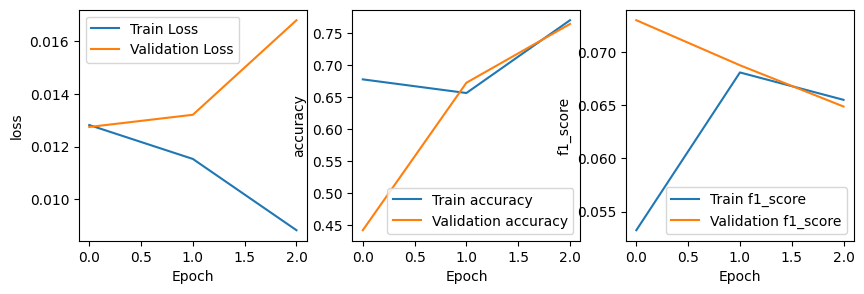

In [ ]:
history = model3.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_val, y_val))
plot_history(history)

In [ ]:
score = model3.evaluate(X_val, y_val, verbose=0)

print("Validation loss:", score[0])
print("Validation accuracy:", score[1])
print("Validation F1-score:", score[2])

Validation loss: 0.016797976568341255
Validation accuracy: 0.7638081312179565
Validation F1-score: 0.05833711847662926


86/86 ━━━━━━━━━━━━━━━━━━━━ 67s 772ms/step


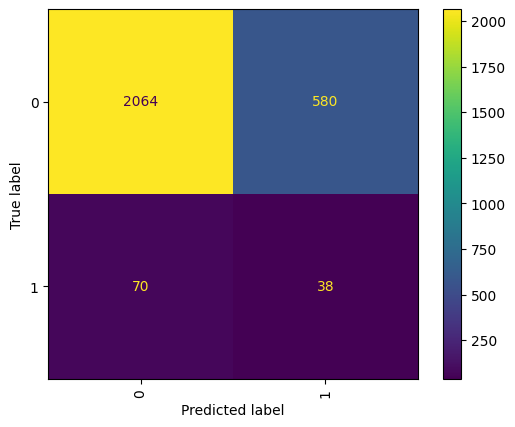

In [ ]:
# Confusion matrix (validation set)
y_pred = model3.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
_ = plt.xticks(rotation=90)